### Set-up the environment and acquire data.

In [1125]:
import glob
import os
import scipy.io
import networkx as nx
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

# Specify the path to the resources folder
folder_path = 'resources/'

# Find all .mat files in the resources folder
file_paths = glob.glob(folder_path + '*.mat')

f = scipy.io.loadmat(os.path.join(folder_path,'flow.mat'))["flow"].reshape(28,)
c = scipy.io.loadmat(os.path.join(folder_path,'capacities.mat'))["capacities"].reshape(28,)
B = scipy.io.loadmat(os.path.join(folder_path,'traffic.mat'))["traffic"]
l = scipy.io.loadmat(os.path.join(folder_path,'traveltime.mat'))["traveltime"].reshape(28,)

In [1126]:
# Original list
original_list = np.array([4, 2, 7, 1, 9])

indices = [4,3,2,1,0]
# Reordered list
reordered_list = original_list[indices]
reordered_list


array([9, 1, 7, 2, 4])

### Define some useful functions

In [1127]:
# Some useful functions

def find_flow(cost_f, exogenous_inflow, B, c, n_edges=28):
    """ Find the flow of equilibrium, minimizing the cost function.
    parameters:
        cost_f: the cost function
        exogenous_inflow: the exogenous inflow
        B: the incidence matrix
        c: the capacities
    returns:
        the flow of equilibrium
    """
    f = cp.Variable(n_edges)
    constraints = [
        f >= 0,
        f <= c,
        B @ f == exogenous_inflow
    ]
    objective = cp.Minimize(cost_f(f))
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.CLARABEL)
    return f.value

def to_gradient(numbers, cmap='blues'):
    # Normalize the numbers to the range [0, 1]
    norm = plt.Normalize(min(numbers), max(numbers))
    
    # Create a color map using the specified colormap
    colormap = plt.colormaps.get_cmap(cmap)
    
    # Convert each number to a color in the gradient
    colors = [colormap(norm(num)) for num in numbers]
    
    return colors

def draw_flow(G, flow, cmap='YlOrRd', title='Flow of equilibrium', fontsize=8):
    """ Draw the graph with the flow of equilibrium.
    parameters:
        G: the graph
        flow: the flow of equilibrium
    """
    # fix the positions of the nodes
    pos = nx.spectral_layout(G, weight='traveltime')

    # rearrange the flow
    indices = list(nx.get_edge_attributes(G, 'order').values())
    flow = np.array(flow)[indices]

    # convert to int
    flow = flow.astype(int)

    # the labels of the edges are the flow
    edge_labels = { e:f for e, f in zip(G.edges, flow)}

    # the colors of the edges are the flow
    edge_colors = to_gradient(flow, cmap)

    # create the axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # draw it
    nx.draw(G, pos, with_labels=True, edge_color=edge_colors, width=3, ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=fontsize, ax=ax)
    
    # Create a ScalarMappable to associate a colormap with the colorbar
    norm = mcolors.Normalize(vmin=np.min(flow), vmax=np.max(flow))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    # Add a colorbar with the ScalarMappable
    cbar = plt.colorbar(sm, ax=ax, shrink=0.4, anchor=(0.5, 0))
    cbar.ax.tick_params(labelsize=fontsize)
    plt.title(title)
    plt.show()

### Create the graph:
Here we add edges and nodes starting from the B matrix: **node-link incidence matrix**.
- tail node = -1
- head node = 1
- all other nodes = 0

Then we add to each edge its **attributes**:
- capacities
- traveltime

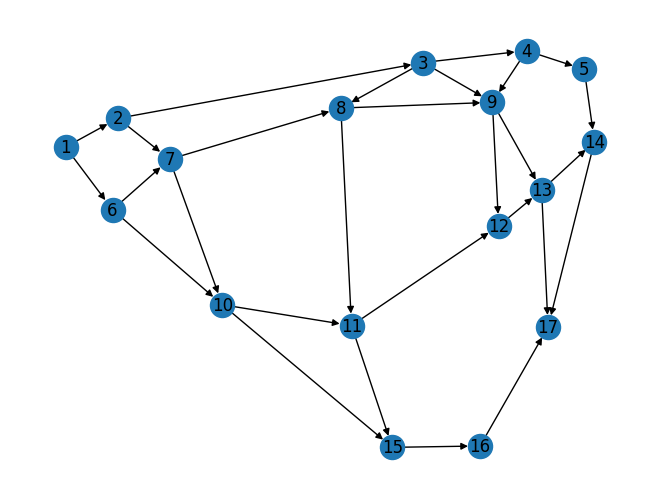

In [1128]:
# Create an empty graph
G = nx.DiGraph()

# Get the number of nodes and links from the shape of B
num_nodes, num_links = B.shape

# Add edges to the graph based on the node-link incidence matrix
for link in range(num_links):
    tail_node = None
    head_node = None
    for node in range(num_nodes):
        if B[node, link] == 1:
            tail_node = node
        elif B[node, link] == -1:
            head_node = node
    if tail_node is not None and head_node is not None:
        edge = (tail_node+1, head_node+1)
        attr = {'capacity': c[link], 'traveltime': l[link], 'order': link}
        G.add_edge(*edge, **attr)

# visualize it
pos = nx.spectral_layout(G, weight='traveltime')
nx.draw(G, with_labels=True, pos=pos)

### (a) Find the shortest path using Dijkstra's algorithm:
There are two ways to find the shortest weighted path from o (source) to d (destination):
1. Consider it as a flow optimization problem.
2. Use a greedy algorithm.

In our case, we adopted the second aproach, we used a greedy algorithm developed by Dijkstra.

#### Dijkstra pseudocode:
Let $ n=|V| $. 

At Step $ i $, where  $ 1≤i≤n $, we will have determined:<br>
1. A sequence  $ σ=(v_1,v_2,v_3,…,v_i) $ of distinct vertices from  G with $ r=v_1 $.<br>
These vertices are called **permanent vertices**, while the remaining vertices will be called **temporary vertices**.<br>
2. For each vertex $ x∈V $ , we will have determined a number $ δ(x) $ and a path $ P(x) $ from $ r $ to $ x $ of length $ δ(x) $.
##### Initialization (Step 1)
- Set $i=1$.<br>
- Set $δ(r)=0$ and let $P(r)=(r)$ be the trivial one-point path.<br>
- Also, set $σ=(r)$.<br>
- For each $x≠r$, set $δ(x)=w(r,x)$ and $P(x)=(r,x)$. <br>
- Let $x$ be a temporary vertex for which $δ(x)$ is minimum. <br>
- Set $v_2=x$, and update $σ$ by appending $v_2$ to the end of it.<br>
- Increment $i$.<br>
##### Inductive Step ( Step $i : i>1$ )
- If $i<n$, then for each temporary $x$ , let: $δ(x)=min{δ(x),δ(v_i)+w(v_i,x)}$
- If this assignment results in a reduction in the value of $δ(x)$ , let $P(x)$ be the path obtained by adding $x$ to the end of $(v_i)$.
- Let $x$ be a temporary vertex for which $δ(x)$ is minimum. 
- Set $v_i+1=x$ , and update $σ$ by appending $v_i+1$ to it. 
- Increment $i$ .


In [1129]:
# (a) Find the shortest path using Dijkstra's algorithm
shortest_path = nx.dijkstra_path(G, source=1, target=17, weight='traveltime')

# Print the shortest path
print("Shortest path:", shortest_path)

Shortest path: [1, 2, 3, 9, 13, 17]


### (b) Find the maximum flow between node 1 and 17
Solving the problem is possible through established algorithms like **Ford-Fulkerson**. However, `NetworkX` presents an alternative off-the-shelf method with its `maximum_flow` function. Specifically, the maximum flow between the two nodes is determined to be 22448.

In [1130]:
# (b) Find the maximum flow between node 1 and 17
max_flow_value, max_flow_dict = nx.maximum_flow(G, 1, 17)

# Print the maximum flow value
print("Maximum flow:", max_flow_value)

Maximum flow: 22448


### (c) Given the flow vector in `flow.mat`, compute the external inflow $ \nu $
We can use the following equation:
$$
Bf = \nu 
$$
After, we compute the **exogenous inflow** useful for the next point (d).
$$
\begin{gathered}
f_{ex} = (\nu_1, 0, ... , 0, -\nu_1 )\text{, with } f_{ex} \in \mathbb{R}^{|V|}
\end{gathered}
$$

In [1131]:
# (c) Given the flow vector in flow.mat, compute the external inflow ν satisfying Bf = ν.

# Calculate the matrix product Bf
v = B @ f

# Print the external inflow ν
print("External inflow v:", v)

# calculate the exogenous inflow
exogenous_inflow = np.array([v[0], *[0]*v[1:-1].size, -v[0]])

External inflow v: [ 16282   9094  19448   4957   -746   4768    413     -2  -5671   1169
     -5  -7131   -380  -7412  -7810  -3430 -23544]


### (d) Find the social optimum $ f^* $
In graph theory, the social optimum refers to a configuration or state in which the **overall welfare** or benefit of the entire network is **maximized**.

In our scenario, the network represents roads, each with its **travel time**. The speed of each road is influenced by congestion, which is described by a **delay function**. The social optimum involves minimizing a **cost function** derived from this delay function.

Essentially, it entails finding the optimal configuration of road usage to collectively **minimize the total travel time**.

Consider the following delay function, for each link $ e $:
$$
\tau_e(f_e)=\tfrac{l_e}{1-f_e/c_e}
$$
and this cost function to be minimized, in order to find $ f^* $:
$$
\sum_{e \in E} f_e\tau_e(f_e) = \sum_{e\in E}\tfrac{f_el_e}{1-f_e/c_e} = \sum_{e\in E}(\tfrac{l_ec_e}{1-f_e/c_e}-l_ec_e)
$$
The complete math modeling:
$$
\min_{\small{\begin{matrix}Bf=\nu\\f\in \mathbb{R}^{\left|E\right|}\\f \geqslant 0\\f \leqslant c\end{matrix}}}{\sum_{e\in E}(\tfrac{l_ec_e}{1-f_e/c_e}-l_ec_e)}
$$

In order to solve this minimization problem, we'll exploit the power of the python library `cvxpy`, able to solve **DCP** problems.


Optimal flow: [6.45395067e+03 5.91921912e+03 2.99536847e+03 2.99536148e+03
 9.82804933e+03 4.49779358e+03 2.89751871e+03 2.43625410e+03
 3.04732610e+03 5.34731546e+02 8.59914090e-02 2.92376466e+03
 6.99113927e-03 2.99536148e+03 5.33025576e+03 2.73093110e+03
 4.73433107e+03 2.13500641e+03 4.61350602e+02 2.31269965e+03
 3.19227402e+03 5.50497366e+03 2.31038879e+03 7.68932085e-03
 6.24191097e+03 5.30575027e+03 4.73433876e+03 4.73433876e+03]
Optimal cost: 23835.487462343524


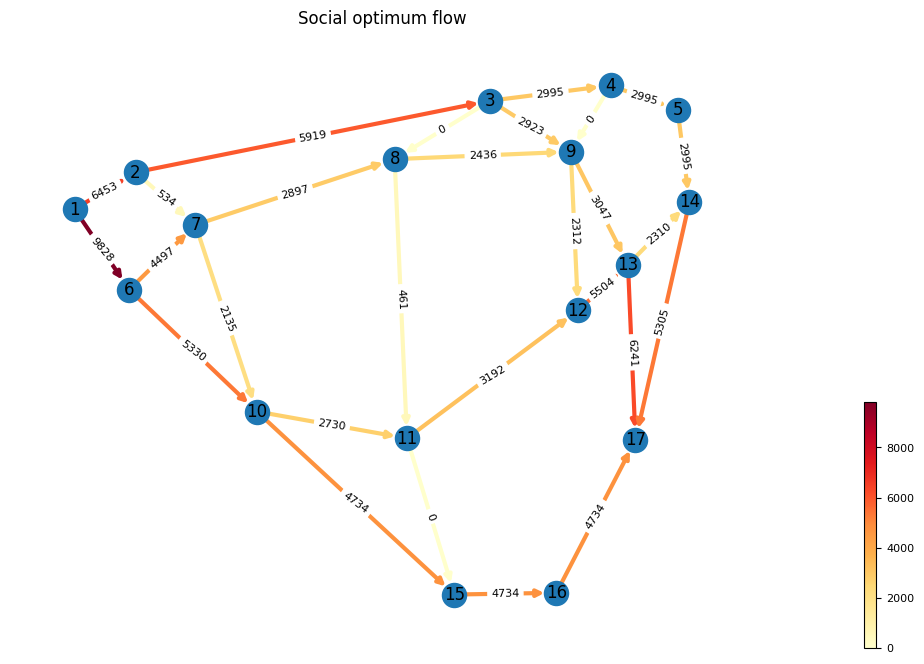

In [1132]:
# (d) Find the social optimum flow from node 1 to node 17.
# Consider that you have to minimize the function of cost.

# Use cvxpy to solve the optimization problem: minimize the cost function.
# The constraints are:
# 1. The flow should be => 0.
# 2. The flow should be <= capacities.
# 3. The flow should satisfy: traffic @ flow = [v[0], ..., v[-1]] = nu.

# Define the cost function.
so_cost_f = lambda x : cp.sum(
    cp.multiply( l*c, cp.inv_pos(1 - x/c)) - l*c
)

so_flow = find_flow(so_cost_f, exogenous_inflow, B, c)

# Print the optimal flow.
print("Optimal flow:", so_flow)
print("Optimal cost:", so_cost_f(so_flow).value)

# draw the graph with the flow of equilibrium
draw_flow(G, so_flow, title='Social optimum flow')

### (e) Find the Wardrop equilibrium $ f^{(0)} $
In the same context, the **Wardrop equilibrium** refers to a state where travelers **selfishly select routes** to minimize their **individual** travel time.

At equilibrium, no traveler can unilaterally decrease their travel time by switching to an alternative route. This condition is often described as a situation where the travel times on all used routes are equal, and any unused route has a longer travel time.

The Wardrop equilibrium captures the idea that, over time, individuals naturally adjust their route choices to achieve a **balanced and stable distribution** of traffic across the network.

In this way the resulting $ f^{(0)} $ will always be **less optimized** than $ f^* $.

This can be proven by computing the **Price of Anarchy**:
$$
PoA = \LARGE{\tfrac{\sum_{e \in E} f^{(0)} \tau_e(f^{(0)} )}{\sum_{e \in E} f^*\tau_e(f^*)}}
$$
In fact it happens to always be:
$$
PoA \geqslant 1
$$

To calculate the Wardrop equilibrium, our objective is to minimize the following cost function:
$$
\sum_{e\in E}\int_{0}^{f^e}\tau_e(s)ds
$$
Here the complete modeling:
$$
\min_{\small{\begin{matrix}Bf=\nu\\f\in \mathbb{R}^{\left|E\right|}\\f \geqslant 0\\f \leqslant c\end{matrix}}}\sum_{e\in E}\int_{0}^{f^e}\tau_e(s)ds
$$
We attempted to calculate the integral using `cvxpy`, by leveraging the fundamental theorem of integration, which involves breaking down the integral of a continuous function into a sum of rectangles.

However, since we were unable to make it **Disciplined Convex Programming** (DCP), we opted to manually compute the primitive function first. Subsequently, we used `cvxpy` to address the minimization problem.

The final cost function, after computing the primitive:
$$
\sum_{e\in E} c_el_e\log(1-f_e/c_e)
$$


Wardrop flow: [6.53248784e+03 6.53248777e+03 2.20678784e+03 2.20678783e+03
 9.74951215e+03 4.49336577e+03 2.71426530e+03 2.20387371e+03
 3.34278815e+03 7.30270094e-05 1.88869797e+02 4.13683014e+03
 8.99353563e-06 2.20678783e+03 5.25614638e+03 2.24738172e+03
 4.78786520e+03 1.77910054e+03 6.99261396e+02 2.99791570e+03
 2.94664311e+03 5.94455881e+03 2.50794234e+03 1.27256630e-05
 6.77940462e+03 4.71473017e+03 4.78786521e+03 4.78786521e+03]
Cost of the Wardrop equilibrium: 24162.201416070533
Price of Anarchy: 1.013707038894974


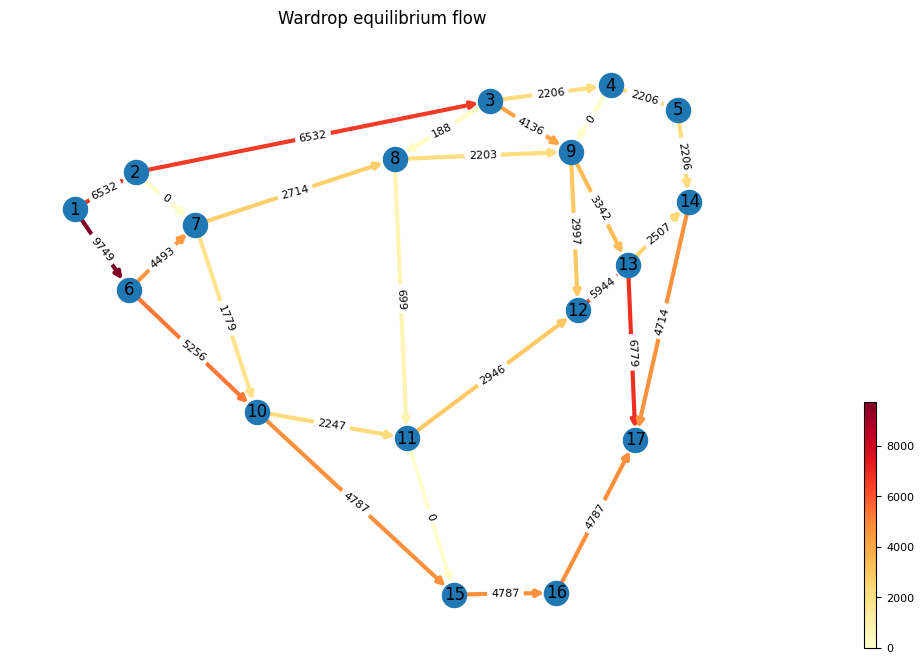

In [1133]:
# (e) Find the Wardrop equilibrium from node 1 to node 17.

# I tried all day to solve it using the fundamental theorem of integration:
# I divided each continue flow function (of each edge) in a number of rectangles, 
# and I tried to minimize the sum of the areas of all the rectangles.

# I couldn't make it DCP, so now I first calculate the integral by hand,
integral = lambda x: - cp.multiply( c*l, cp.log(1 - x/c))

# Define the cost function (the sum of the integrals)
war_cost_f = lambda b, a=0 : cp.sum(integral(b) - integral(a))

# Find the Wardrop equilibrium
wardrop_flow = find_flow(war_cost_f, exogenous_inflow, B, c)
print("Wardrop flow:", wardrop_flow)

# print the cost of the Wardrop equilibrium
print("Cost of the Wardrop equilibrium:", so_cost_f(wardrop_flow).value)

PoA = so_cost_f(wardrop_flow).value/so_cost_f(so_flow).value

print("Price of Anarchy:", PoA)

# draw the graph with the flow of equilibrium
draw_flow(G, wardrop_flow, title='Wardrop equilibrium flow')

### (f) Compute again the Wardrop equilibrium with tolls
Tolls in the Wardrop equilibrium **alter route choices** by introducing a **cost factor**. 

The use of tolls in the context of **Wardrop equilibrium** can lead to the **social optimum** by influencing travelers to choose routes that collectively minimize overall congestion and travel time. Tolls act as incentives, guiding individuals to make choices that align with the broader goal of optimizing traffic flow and reducing congestion across the entire road network.

It's really important to choose a vector of tolls $ \omega^* $ which allows the new **Wardop equilibrium** $ f^{(\omega^*)} $ to coincide with the **social optimum** $ f^* $.

This is true when the **Price of Anarchy** tends to 1:
$$
PoA \cong 1
$$

Here is the general function describing the toll for each edge $ e $:
$$
\omega_e = \psi_e'(f_e^*) - \tau_e(f_e^*) \text{ , where }
\begin{cases}
\psi_e(f_e)\text{ is the cost function}\\
f_e^*\text{ is the optimal flow}
\end{cases}
$$
In our case:
$$
\omega_e = f_e^*\tau_e'(f_e^*)
$$
Consider the new delay function $ \tau_e^1 $ for edge $ e $:
$$
\tau_e^1(f_e) = \tau_e(f_e) + \omega_e
$$
and so the new cost function:
$$
\psi(\vec{f}) = \sum_{e\in E}\int_0^{f_e}\tau_e(s) + \omega_eds
$$
which, after computing the primitive, becomes:
$$
\psi(\vec{f}) = \sum_{e\in E}\{\omega_e f_e - c_e l_e \log(1-f_e/c_e)\}
$$


Wardrop flow: [6.45522607e+03 5.91999374e+03 2.99503902e+03 2.99503899e+03
 9.82677390e+03 4.49376799e+03 2.89690100e+03 2.43529706e+03
 3.04736279e+03 5.35232338e+02 2.06840099e-04 2.92495451e+03
 3.36670133e-05 2.99503899e+03 5.33300592e+03 2.73076063e+03
 4.73434461e+03 2.13209933e+03 4.61604144e+02 2.31288881e+03
 3.19236473e+03 5.50525354e+03 2.31091121e+03 4.17318652e-05
 6.24170512e+03 5.30595020e+03 4.73434466e+03 4.73434466e+03]
Cost of the Wardrop equilibrium with tolls: 23835.489829901344
Price of Anarchy: 1.0000000993291127


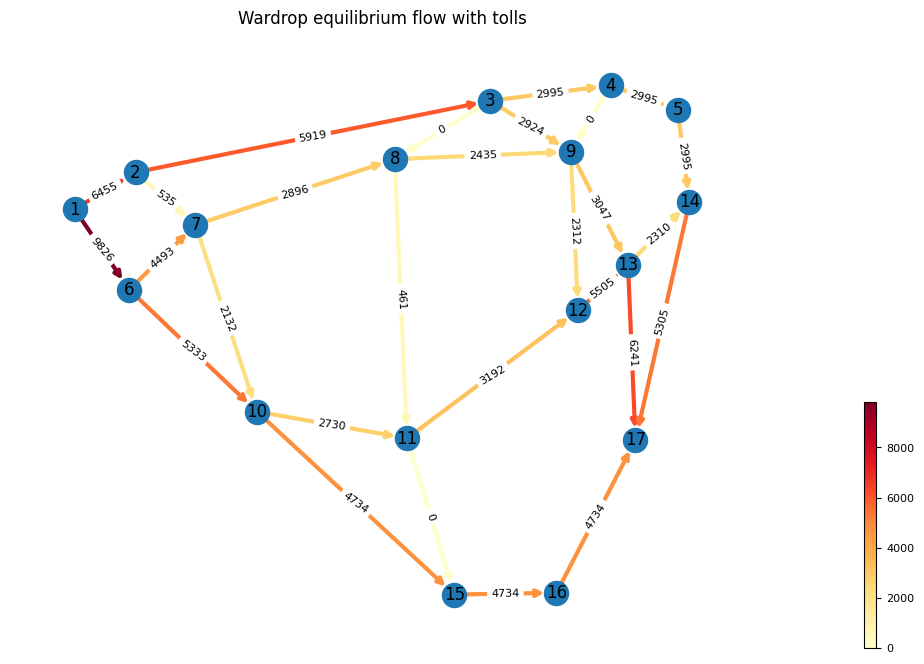

In [1134]:
# (f) Compute again the Wardrop equilibrium, using tolls

# define omega: d/dx[ Te(so_flow) ] * so_flow
omega = lambda x: x*c*l / (c-x)**2

# compute the tolls
w = omega(so_flow)

# Define the cost function:
# again, I first calculate the integral by hand, this time:
# integral[ w + Te(x) ]dx
integral = lambda x: cp.multiply(w, x) - cp.multiply( c*l, cp.log(1 - x/c))

# Define the cost function (the sum of the integrals)
war_tolls_cost_f = lambda b, a=0 : cp.sum(integral(b) - integral(a))

# Find the Wardrop equilibrium
war_tolls_flow = find_flow(war_tolls_cost_f, exogenous_inflow, B, c)

# print the optimal flow
print("Wardrop flow:", war_tolls_flow)

# print the cost of the Wardrop equilibrium
print("Cost of the Wardrop equilibrium with tolls:", so_cost_f(war_tolls_flow).value)

new_PoA = so_cost_f(war_tolls_flow).value/so_cost_f(so_flow).value
# print the price of anarchy
print("Price of Anarchy:", new_PoA)

# draw the graph with the flow of equilibrium
draw_flow(G, war_tolls_flow, title='Wardrop equilibrium flow with tolls')

### (g) Compute again, modifing the original cost function
Instead of the total travel time, let the cost for the system be the total additional travel time compared to the total travel time in free flow:
$$
\psi_e(f_e) = f_e(\tau_e(f_e) - l_e)
$$
Compute:
1. The new system optimum $ f^* $
2. The new toll vector $ \omega^* $ such that $ f^{(\omega^*)} $ coincides with f^*
3. The new Wardrop equilibrium, to prove the above (PoA).

### (g.1) Compute $ f^* $
The new complete math modeling:
$$
f^* = \argmin_{\small{\begin{matrix}Bf=\nu\\f\in \mathbb{R}^{\left|E\right|}\\f \geqslant 0\\f \leqslant c\end{matrix}}}{\sum_{e\in E}(\tfrac{l_ec_e}{1-f_e/c_e}-l_ec_e - f_e l_e)}
$$

As always, solved using `cvxpy`.

Optimal flow: [6.46807754e+03 5.61760436e+03 3.29771511e+03 3.29771002e+03
 9.81392246e+03 4.50159967e+03 3.00297802e+03 2.56434757e+03
 2.91776777e+03 8.50473175e+02 9.92758845e-03 2.31987932e+03
 5.09474663e-03 3.29771002e+03 5.31232279e+03 2.93167148e+03
 4.72974614e+03 2.34909483e+03 4.38640375e+02 1.96646422e+03
 3.37030850e+03 5.33677272e+03 2.14283522e+03 3.35229794e-03
 6.11170526e+03 5.44054524e+03 4.72974950e+03 4.72974950e+03]
Cost of the optimal flow: 13334.30511991761


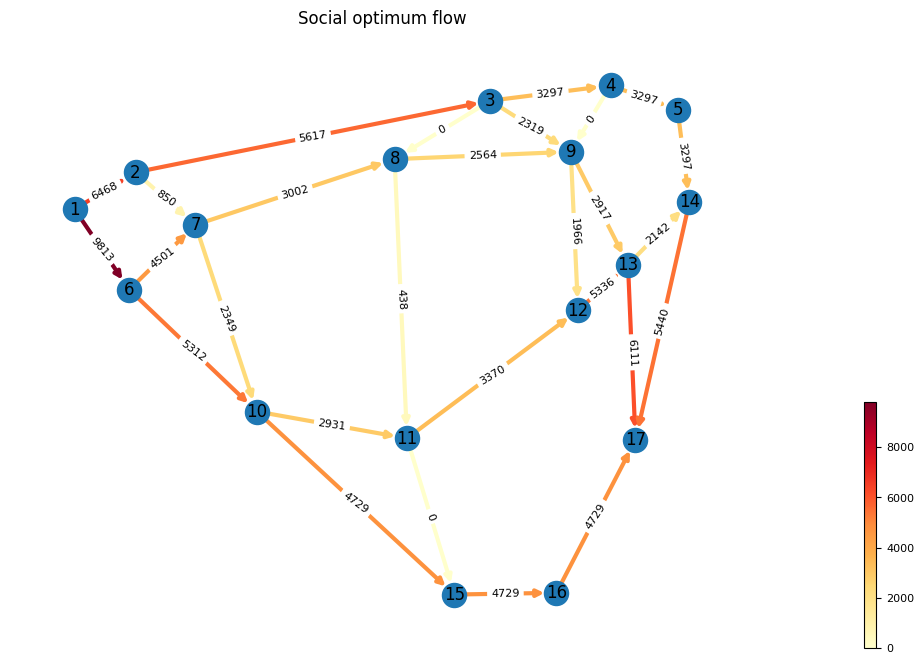

In [1135]:
# (g) Instead of the total travel time, let the cost for the system be the total additional travel time
# compared to the total travel time in free flow.

# (g.1) Compute the social optimum flow from node 1 to node 17.

# Define the cost function.
free_so_cost_f = lambda x : so_cost_f(x) - cp.sum(cp.multiply(x, l))

# Find the optimum flow.
free_so_flow = find_flow(free_so_cost_f, exogenous_inflow, B, c)

# Print the optimal flow.
print("Optimal flow:", free_so_flow)

# Print the cost of the optimal flow.
print("Cost of the optimal flow:", free_so_cost_f(free_so_flow).value)

# draw the graph with the flow of equilibrium
draw_flow(G, free_so_flow, title='Social optimum flow')

### (g.2) Compute the new $ \vec{\omega^*} $
From the general function to compute $ \omega $ described before, we can derive our:
$$
\begin{gathered}
\omega_e^* = \psi_e'(f_e^*) - \tau_e(f_e^*)
= \tfrac{d}{df_e^*}f_e^*(\tau_e(f_e^*) - l_e)- \tau_e(f_e^*) = \\
= \tfrac{d}{df_e^*}f_e^*(\tfrac{l_e}{1-f_e^*/c_e} - l_e)- \tfrac{l_e}{1-f_e^*/c_e}
= \tfrac{l_e(c_e^2 - 3c_e f_e^* + f_e^{*,2})}{(c_e - f_e^*)^2}
\end{gathered}
$$
In the end we can say:
$$
\LARGE{\omega_e^* = \tfrac{l_e(c_e^2 - 3c_e f_e^* + f_e^{*,2})}{(c_e - f_e^*)^2}}
$$

In [1136]:
# (g.2) Compute the Wardrop equilibrium from node 1 to node 17.
# define omega: d/dx[ Te(flow) ] * flow - l
# consider that the derivative of the delay function is the same as before.
omega = lambda x: - cp.multiply(
    l*c**2 - cp.multiply(l*3*c, x) + cp.multiply(l, x**2),
    cp.inv_pos((c-x)**2)
)
w = omega(free_so_flow)

### (g.3) Compute the new Wardrop equilibrium and PoA
In order to compute the new Wadrop equilibrium we have to define the new cost function:
$$
\psi_e(f_e) = \int_0^{f_e}(\tau_e(s) - l_e + \omega_e)ds
$$
After computing the primitive:
$$
\psi_e(f_e) = \omega_e f_e - l_e f_e - c_e l_e \log(1 - f_e/c_e)
$$

Wardrop flow: [6.47012938e+03 5.61986356e+03 3.29654197e+03 3.29654171e+03
 9.81187058e+03 4.49883728e+03 3.00303839e+03 2.56358960e+03
 2.91674887e+03 8.50265821e+02 3.80523852e-04 2.32332121e+03
 2.59261059e-04 3.29654171e+03 5.31303330e+03 2.92860588e+03
 4.73049213e+03 2.34606471e+03 4.39449169e+02 1.97016221e+03
 3.36805494e+03 5.33821715e+03 2.14509624e+03 1.02455152e-04
 6.10986978e+03 5.44163795e+03 4.73049223e+03 4.73049223e+03]
Cost of the Wardrop equilibrium with tolls: 13334.315014234311
Price of Anarchy: 1.0000007420196713


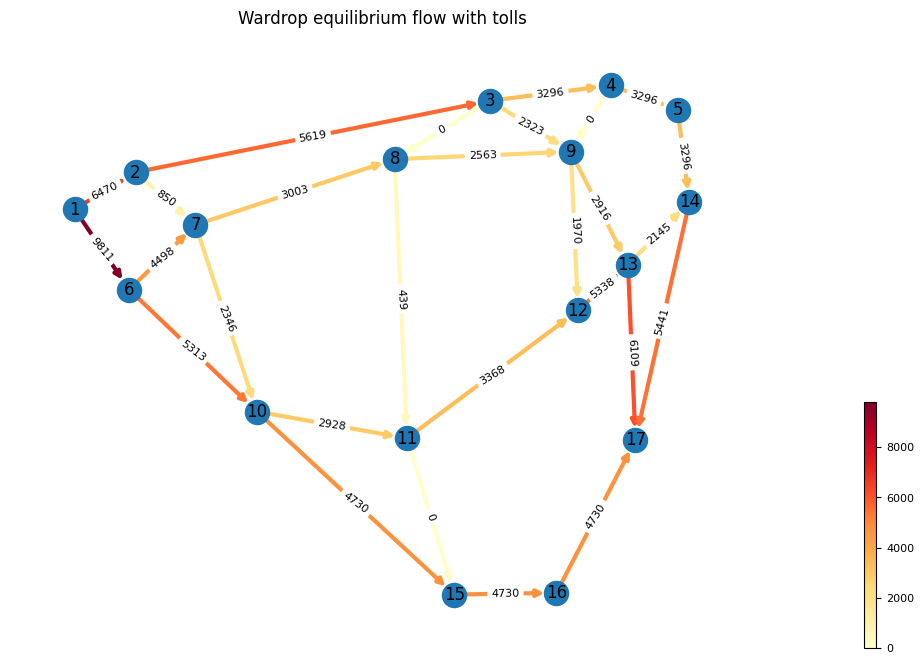

In [1137]:
# (g.3) Compute new Wardrop equilibrium and PoA.
# Define the cost function:
# again, I first calculate the integral by hand, this time:
# integral[ w + Te(x) ]dx
integral = lambda x: cp.multiply(w, x) - cp.multiply(l, x)- cp.multiply( c*l, cp.log(1 - x/c))

# Define the cost function (the sum of the integrals)
war_tolls_free_cost_f = lambda b, a=0 : cp.sum(integral(b) - integral(a))

war_tolls_free_flow = find_flow(war_tolls_free_cost_f, exogenous_inflow, B, c)

# print the optimal flow
print("Wardrop flow:", war_tolls_free_flow)

# print the cost of the Wardrop equilibrium
print("Cost of the Wardrop equilibrium with tolls:", free_so_cost_f(war_tolls_free_flow).value)

# print the price of anarchy
new_PoA = free_so_cost_f(war_tolls_free_flow).value/free_so_cost_f(free_so_flow).value

print("Price of Anarchy:", new_PoA)

# draw the graph with the flow of equilibrium
draw_flow(G, war_tolls_free_flow, title='Wardrop equilibrium flow with tolls')